In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridFD():
    '''
    Define the grid in a finite difference framework
    Note: the size should be the number of intervals, e.g., 
          there are n-1 internal grid points if the size is n
    '''
    def __init__(self, size, sigma):
        self.size = size
        self.sigma = sigma
        self.v = np.zeros(size-1)
        self.f = np.zeros(size-1)
        self.A = self.ModelProblem()

    def IsCoarsest(self):
        return self.size == 2

    def BoundaryPadding(self):
        self.v = np.pad(self.v, pad_width=1) # only consider zero boundary
    
    def ModelProblem(self):
        '''
        Construct the linear equation system Ax = b for a temperature distribution problem:
            -u"(x) + sigma*u(x) = f(x), 0<x<1, sigma >= 0
            u(0) = u(1) = 0

        Finite difference stencil is 1/(h^2)[-1  2+sigma*h^2  -1]
        ''' 
        h = 1.0/self.size
        A = np.zeros((self.size+1,self.size+1))
        for i in range(1,self.size):
            A[i,i-1:i+2] = [-1.0/h/h, self.sigma+2.0/h/h, -1.0/h/h]
        return A[1:self.size,1:self.size]

In [3]:
class Multigrid():
    '''
    Define the multigrid problem
    '''
    def __init__(self, n = 64):

        # Problem parameters
        sigma = 1
        C = 5.0
        k = 3

        self.n = 64 # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(0,1,n+1)[1:n]
        self.u_exact = C/(np.power(np.pi*k,2)+sigma)*np.sin(k*np.pi*self.x) # exact solution

        self.size_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict(sigma) # dictionary of structure grids

        self.restrict_op = self.RestrictOp() # list of restriction operators
        self.interpolate_op = self.InterpolateOp() # list of interpolation operators

        #f = C*np.sin(k*np.pi*x) 
        f = np.dot(self.grids[0].A,self.u_exact)
        self.grids[0].f = f # assign the finest right hand side with the original rhs

    def GridDict(self, sigma):
        grids = {}
        for i in range(self.L):
            grids[i] = GridFD(self.size_arr[i],sigma)
        return grids

    def SizeArray(self):
        size_arr = []
        for i in range(self.L):
            size_arr.append(int(self.n/(2.**i)))
        size_arr = np.array(size_arr)
        return size_arr

    def RestrictOp(self):
        restrict_op = []
        for i in range(self.L-1):
            size_current = self.size_arr[i]
            size_next = self.size_arr[i+1]
            res_temp = np.zeros((size_next+1,size_current+1))
            stencil = 1./4.*np.array([1,2,1])
            for j in range(size_next-1):
               res_temp[j+1,2*j+1:2*j+4] = stencil
            restrict_op.append(res_temp[1:-1,1:-1])
        return restrict_op

    def InterpolateOp(self):
        interpolate_op = [None]
        for i in range(1,self.L):
            size_current = self.size_arr[i]
            size_prev = self.size_arr[i-1]
            int_temp = np.zeros((size_prev+1,size_current+1))
            stencil = 1./2.*np.array([1,2,1])
            for j in range(size_current-1):
                int_temp[2*j+1:2*j+4,j+1] = stencil
            interpolate_op.append(int_temp[1:-1,1:-1])
        return interpolate_op

    def Error(self,v):
        '''Compute the error between current approximation and exact solution'''
        return np.linalg.norm(v-self.u_exact, ord=np.inf)

In [4]:
def Relax(A, f, v0, num_sweeps_down):
    '''
    Perform a fixed number of weighted Jacobi iterations, given initial solution v0
    '''
    omega = 2./3.
    Dinv = np.diag(1.0/np.diag(A))
    v = v0
    for i in range(num_sweeps_down):
        vprev = v
        residual = f - np.dot(A,vprev)
        v = omega*np.dot(Dinv,residual) + vprev
    return v

def Restrict(restrict_op, f):
    '''
    Perform full weighting operation to down sample to next level
    '''
    return np.dot(restrict_op,f)

def Interpolate(interpolate_op, v):
    '''
    Perform linear interpolation to up sample to previous level
    '''
    return np.dot(interpolate_op,v)

0.05566289860445797
0.055256773769707425
0.05485361208250284
0.05445339192327648
0.05405609183020018
0.053661690498034514
0.05327016677698626
0.05288149967157423
0.05249566833950344
0.0521126520905474
0.05173243038543857
0.05135498283476704
0.050980289197887045
0.0506083293818316
0.050239083440235026
0.049872531572263304
0.049508654121552274
0.04914743157515353
0.04878884456248807
0.04843287385430752
0.04807950036166301
0.047728705134881456
0.04738046936254946
0.04703477437050447
0.04669160162083346
0.04635093271087876
0.04601274937225127
0.045677033469850754
0.04534376700089341
0.045012932093946426
0.04468451100796964
0.04435848613136418
0.04403483998102802
0.04371355520141847
0.04339461456362148
0.04307800096442773
0.042763697425415456
0.04245168709204004
0.042141953232730095
0.041834479237990316
0.04152924861951075
0.04122624500928262
0.04092545215872058
0.04062685393779141
0.04033043433414902
0.04003617745227578
0.03974406751263015
0.03945408885080047
0.03916622591666499
0.03888046

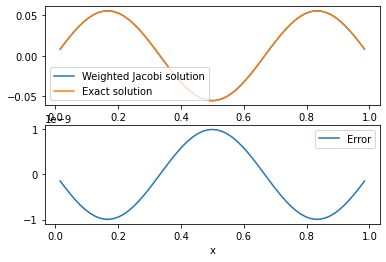

In [5]:
## Test the weighted Jacobi iteration
n = 64
prob_rV = Multigrid(n)

EPS = 1e-9
n_jacobi = 0
u_jacobi = np.zeros(n-1)
e_jacobi = prob_rV.Error(u_jacobi)
e_arr_jacobi = [0,e_jacobi]
while (e_jacobi>EPS):
    print(e_jacobi)
    n_jacobi += 1
    u_jacobi = Relax(prob_rV.grids[0].A, prob_rV.grids[0].f, u_jacobi, 1)
    e_jacobi = prob_rV.Error(u_jacobi)
    e_arr_jacobi.append(e_jacobi)

print("Solution converges after ", n_jacobi, "weighted Jacobi iterations")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(prob_rV.x,u_jacobi,label='Weighted Jacobi solution')
ax1.plot(prob_rV.x,prob_rV.u_exact,label='Exact solution')
ax1.legend()
ax2.plot(prob_rV.x,u_jacobi-prob_rV.u_exact,label='Error')
ax2.set_xlabel('x')
ax2.legend()
plt.show()

In [6]:
## Test the V-cycle multigrid iteration
def V_cycle(grids, op, l, v, f):
    '''
    l: current level
    f: rhs vector for current level
    '''
    n_sample = 1
    grids[l].v = v
    grids[l].f = f
    grids[l].v = Relax(grids[l].A, grids[l].f, grids[l].v, n_sample)
    
    L = len(grids) 
    for j in range(l,L-1):
        grids[j+1].f = Restrict(op['r'][j], grids[j].f - np.dot(grids[j].A, grids[j].v))
        grids[j+1].v *= 0.
        grids[j+1].v = Relax(grids[j+1].A, grids[j+1].f, grids[j+1].v, n_sample)

    grids[L-1].v = Relax(grids[L-1].A, grids[L-1].f, grids[L-1].v, n_sample) # highest level

    for j in range(L-2,l-1,-1):
        grids[j].v = grids[j].v + Interpolate(op['i'][j+1], grids[j+1].v)
        grids[j].v = Relax(grids[j].A, grids[j].f, grids[j].v, n_sample)

        # zero out the previous level solution
        grids[j+1].v *= 0.
    
    return grids[l].v

0.05566289860445797
0.010535323164032565
0.002009375212781536
0.000385354838857134
7.407433918522888e-05
1.4249836413647576e-05
2.7414308577458635e-06
5.272678017947952e-07
1.0137110582897346e-07
1.9480838844843085e-08
3.742073963197701e-09
Solution converges after  11 V-cycle iterations


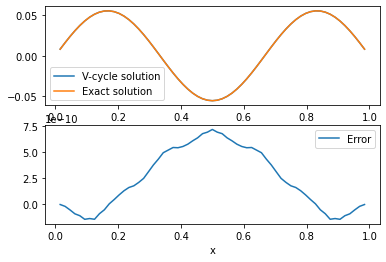

In [7]:
n = 64
prob_rV = Multigrid(n)
operators = {'i': prob_rV.interpolate_op,
             'r': prob_rV.restrict_op }

EPS = 1e-9
n_V_cycle = 0
u_cycle = np.zeros(n-1)
f_cycle = prob_rV.grids[0].f
e_V_cycle = prob_rV.Error(u_cycle)
e_arr_Vcycle = [0,e_V_cycle]
while (e_V_cycle>EPS):
    print(e_V_cycle)
    u_cycle = V_cycle(prob_rV.grids,operators,0,u_cycle,f_cycle)
    e_V_cycle = prob_rV.Error(u_cycle)
    e_arr_Vcycle.append(e_V_cycle)
    n_V_cycle += 1

print("Solution converges after ", n_V_cycle, "V-cycle iterations")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(prob_rV.x,u_cycle,label='V-cycle solution')
ax1.plot(prob_rV.x,prob_rV.u_exact,label='Exact solution')
ax1.legend()
ax2.plot(prob_rV.x,u_cycle-prob_rV.u_exact,label='Error')
ax2.set_xlabel('x')
ax2.legend()
plt.show()

In [8]:
# recursive V-cycle
def rec_V_cycle(grids, op, l, v, f):
    '''
    Perform recursive V-cycle
    Input: grids, dictionary of FD grids;
           op, dictionary of operators;
           l, current level
    '''
    n_sample = 1
    grids[l].v = v
    grids[l].f = f

    grids[l].v = Relax(grids[l].A, grids[l].f, grids[l].v, n_sample)
    if(not grids[l].IsCoarsest()):
        grids[l+1].f = Restrict(op['r'][l], grids[l].f - np.dot(grids[l].A, grids[l].v))
        grids[l+1].v *= 0.
        grids[l+1].v = rec_V_cycle(grids, op, l+1, grids[l+1].v, grids[l+1].f)
        grids[l].v = grids[l].v + Interpolate(op['i'][l+1], grids[l+1].v)
        grids[l+1].v *= 0.
        
    grids[l].v = Relax(grids[l].A, grids[l].f, grids[l].v, n_sample)
    return grids[l].v

0.05566289860445797
0.010535323164032565
0.002009375212781536
0.000385354838857134
7.407433918522888e-05
1.4249836413647576e-05
2.7414308577458635e-06
5.272678017947952e-07
1.0137110582897346e-07
1.9480838844843085e-08
3.742073963197701e-09
Solution converges after  11 V-cycle iterations


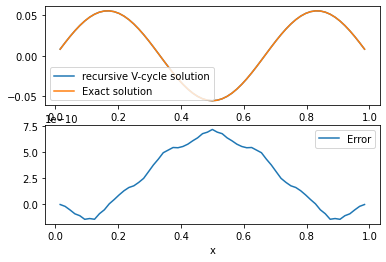

In [9]:
n = 64
prob_rV = Multigrid(n)
operators = {'i': prob_rV.interpolate_op,
             'r': prob_rV.restrict_op }

EPS = 1e-9
n_recV_cycle = 0
u_rec_cycle = np.zeros(n-1)
f_cycle = prob_rV.grids[0].f
e_recV_cycle = prob_rV.Error(u_rec_cycle)
e_arr_recVcycle = [0,e_recV_cycle]
while (e_recV_cycle>EPS):
    print(e_recV_cycle)
    u_rec_cycle = rec_V_cycle(prob_rV.grids,operators,0,u_rec_cycle,f_cycle)
    e_recV_cycle = prob_rV.Error(u_rec_cycle)
    e_arr_recVcycle.append(e_recV_cycle)
    n_recV_cycle += 1

print("Solution converges after ", n_recV_cycle, "V-cycle iterations")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(prob_rV.x,u_rec_cycle,label='recursive V-cycle solution')
ax1.plot(prob_rV.x,prob_rV.u_exact,label='Exact solution')
ax1.legend()
ax2.plot(prob_rV.x,u_rec_cycle-prob_rV.u_exact,label='Error')
ax2.set_xlabel('x')
ax2.legend()
plt.show()

In [10]:
def FMG(grids, op, l, v, f):
    '''
    l: current level
    f: current rhs vector
    '''
    n_sample = 1
    grids[l].v = v
    grids[l].f = f

    L = len(grids) 
    for j in range(l,L-1):
        grids[j+1].f = Restrict(op['r'][j], grids[j].f - np.dot(grids[j].A, grids[j].v))
        grids[j+1].v *= 0.

    grids[L-1].v = Relax(grids[L-1].A, grids[L-1].f, grids[L-1].v, n_sample)

    for j in range(L-2,l-1,-1):
        grids[j].v = grids[j].v + Interpolate(op['i'][j+1], grids[j+1].v)
        grids[j].v = V_cycle(grids, op, j, grids[j].v, grids[j].f)

        # zero out the previous level solution
        grids[j+1].v *= 0.
    
    return grids[l].v

0.05566289860445797
9.826075906144843e-05
7.48091934402173e-06
7.677636905678575e-07
7.902526519276698e-08
8.13513268554944e-09
Solution converges after  6 FMG iterations


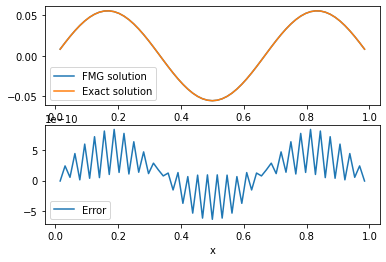

In [11]:
n = 64
prob_rV = Multigrid(n)
operators = {'i': prob_rV.interpolate_op,
             'r': prob_rV.restrict_op }

EPS = 1e-9
n_FMG = 0
u_FMG = np.zeros(n-1)
f_cycle = prob_rV.grids[0].f
e_FMG = prob_rV.Error(u_FMG)
e_arr_FMG = [0,e_FMG]
while (e_FMG>EPS):
    print(e_FMG)
    u_FMG = FMG(prob_rV.grids,operators,0,u_FMG,f_cycle)
    e_FMG = prob_rV.Error(u_FMG)
    e_arr_FMG.append(e_FMG)
    n_FMG += 1

print("Solution converges after ", n_FMG, "FMG iterations")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(prob_rV.x,u_FMG,label='FMG solution')
ax1.plot(prob_rV.x,prob_rV.u_exact,label='Exact solution')
ax1.legend()
ax2.plot(prob_rV.x,u_FMG-prob_rV.u_exact,label='Error')
ax2.set_xlabel('x')
ax2.legend()
plt.show()

In [12]:
def rec_FMG(grids, op, l, v, f):
    '''
    Perform recursive FMG
    '''
    n_sample = 1
    grids[l].v = v
    grids[l].f = f

    if(not grids[l].IsCoarsest()):
        grids[l+1].f = Restrict(op['r'][l], grids[l].f - np.dot(grids[l].A, grids[l].v))
        grids[l+1].v *= 0.
        grids[l+1].v = rec_FMG(grids, op, l+1, grids[l+1].v, grids[l+1].f)
        grids[l].v = grids[l].v + Interpolate(op['i'][l+1], grids[l+1].v)
        grids[l+1].v *= 0.
        
    grids[l].v = Relax(grids[l].A, grids[l].f, grids[l].v, n_sample)
    return grids[l].v

0.05566289860445797
9.826075906144843e-05
7.48091934402173e-06
7.677636905678575e-07
7.902526519276698e-08
8.13513268554944e-09
Solution converges after  6 recursive FMG iterations


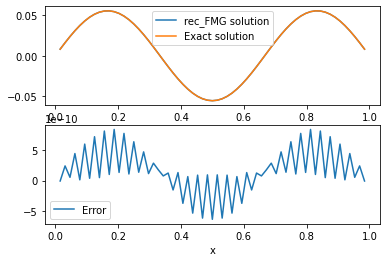

In [13]:
n = 64
prob_rV = Multigrid(n)
operators = {'i': prob_rV.interpolate_op,
             'r': prob_rV.restrict_op }

EPS = 1e-9
n_recFMG = 0
u_recFMG = np.zeros(n-1)
f_cycle = prob_rV.grids[0].f
e_recFMG = prob_rV.Error(u_recFMG)
e_arr_recFMG = [0,e_recFMG]
while (e_recFMG>EPS):
    print(e_recFMG)
    u_recFMG = FMG(prob_rV.grids,operators,0,u_recFMG,f_cycle)
    e_recFMG = prob_rV.Error(u_recFMG)
    e_arr_recFMG.append(e_recFMG)
    n_recFMG += 1

print("Solution converges after ", n_recFMG, "recursive FMG iterations")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(prob_rV.x,u_recFMG,label='rec_FMG solution')
ax1.plot(prob_rV.x,prob_rV.u_exact,label='Exact solution')
ax1.legend()
ax2.plot(prob_rV.x,u_recFMG-prob_rV.u_exact,label='Error')
ax2.set_xlabel('x')
ax2.legend()
plt.show()

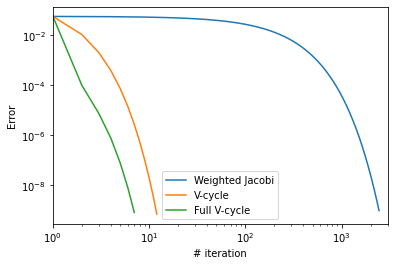

In [17]:
# Plot the error
plt.plot(e_arr_jacobi, label='Weighted Jacobi')
plt.plot(e_arr_recVcycle, label='V-cycle')
plt.plot(e_arr_recFMG, label='Full V-cycle')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,3000])
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()